In [1]:
%env OMP_NUM_THREADS = 1

from firedrake import *
import numpy as np
from petsc4py import PETSc
from slepc4py import SLEPc
import matplotlib.pyplot as plt

def transform_coordinates(A, theta_1, theta_2):
    B = A
    a = (pi-theta_2)/(pi-theta_1)
    b = pi-a*pi
    
    # Change to polar coordinates
    r = np.sqrt(B[:,0]**2+B[:,1]**2)
    t = np.arctan2(B[:,1], B[:,0])
    
    # Find index of positive y
    i_p = B[:,1] >= 0
    i_m = B[:,1] < 0
    
    # Interpolate angles
    t[i_p] = a*t[i_p] + b   
    t[i_m] = a*t[i_m] - b
    
    # Convert to cartesian coordinates
    B[:,0] = r*np.cos(t)
    B[:,1] = r*np.sin(t)
    
    return B

env: OMP_NUM_THREADS=1


In [2]:
def evproblem(theta = pi/2):
    # Base mesh with angle theta_1 = pi/2
    basemesh = Mesh("pacman.msh")
    theta_0 = pi/2
    theta = 0.55*pi
    Vc = basemesh.coordinates.function_space()
    x, y = SpatialCoordinate(basemesh)
    m = Function(Vc).interpolate(as_vector([x, y]))

    m.dat.data[:] = transform_coordinates(m.dat.data[:], theta_0/2, theta/2)
    mesh = Mesh(m)

    Vc = mesh.coordinates.function_space()
    x, y = SpatialCoordinate(mesh)

    # Interpolator function for changing mesh coordinates
    f = Function(Vc).interpolate(as_vector([x, y]))

    # New mesh depending on f
    new_mesh = Mesh(f)

    # Transform mesh
    theta_2 = pi
    #f.dat.data[:] = transform_coordinates(f.dat.data[:], theta_1/2, theta_2/2)

    # Vector function space
    V = FunctionSpace(new_mesh, "CG", 3)

    # Solution to Laplace equation
    u = Function(V, name="u")
    v = TestFunction(V)
    rhs = Function(V).assign(1.0)

    # Weak form
    F = inner(grad(u),grad(v))*dx - rhs*v*dx

    # Boundary conditions
    bcs = [DirichletBC(V, Constant(0.0), "on_boundary")]

    solver_parameters = {
                     "mat_type": "aij",
                     "eps_monitor_conv" : None,
                     "eps_converged_reason": None,
                     "eps_type": "krylovschur",
                     "eps_nev" : 10,
                     "eps_max_it": 50,
                     "eps_tol" : 1e-15,
                     "eps_target" : 0,
                     "eps_which": "smallest_magnitude",
                     "st_type": "sinvert",
                     "st_ksp_type": "preonly",
                     "st_pc_type": "lu",
                     "st_pc_factor_mat_solver_type": "mumps",
                     "st_ksp_max_it": 10,
                     "ds_parallel": "synchronized"
                     }

    opts = PETSc.Options()
    for k in solver_parameters:
        opts[k] = solver_parameters[k]

    u = TrialFunction(V)
    v = TestFunction(V)
    stabform = inner(grad(u),grad(v))*dx
    massform = inner(u,v)*dx

    M = assemble(massform, bcs=bcs, mat_type="aij")

    # There must be a better way of doing this
    from firedrake.preconditioners.patch import bcdofs
    for bc in bcs:
        M.M.handle.zeroRowsColumns(bcdofs(bc), diag=0)
    stabmass = M

    comm = V.mesh().comm

    A = assemble(stabform, bcs=bcs, mat_type="aij")

    # Create the SLEPc eigensolver
    eps = SLEPc.EPS().create(comm=comm)
    eps.setOperators(A.M.handle, stabmass.M.handle)
    eps.setProblemType(eps.ProblemType.GNHEP)
    eps.setFromOptions()

    eps.solve()
    eigenvalues = []
    eigenfunctions = []
    eigenfunction = Function(V, name="Eigenfunction")

    for i in range(eps.getConverged()):
        lmbda = eps.getEigenvalue(i)
        eigenvalues.append(lmbda)
        with eigenfunction.dat.vec_wo as x:
            eps.getEigenvector(i,x)
        # normalize eigenfunction
        eigenfunction.assign((1/norm(eigenfunction))*eigenfunction)
        eigenfunctions.append(eigenfunction.copy(deepcopy=True))
        # plt.figure()
        # levels = np.linspace(np.min(eigenfunction.dat.data), np.max(eigenfunction.dat.data), 20)
        # contours = tricontourf(eigenfunction, levels = levels, axes = plt.gca(),cmap="jet")
        # plt.gca().set_aspect('equal', adjustable='box')
        # plt.colorbar(contours, fraction=0.046, pad=0.04)
        # plt.title(f'Mode {i}: {lmbda:.2f}')

    # print(eigenvalues)
    # print("number eigenvalues = %d"%len(eigenvalues))
    return eigenvalues, eigenfunctions

In [3]:
# Base mesh with angle theta_1 = pi/2

Theta = np.array([0.4*pi, 0.5*pi, 0.6*pi])
EF = []
EV = []
for theta in Theta:
    eigenvalues, eigenfunctions = evproblem(theta)
    EV.append(eigenvalues)
    EF.append(eigenfunctions)

EF = np.array(EF)
EV = np.array(EV)

  1 EPS converged value (error) #0 11.6299 (2.00480645e-28)
  1 EPS converged value (error) #1 18.8272 (1.15503058e-19)
  1 EPS converged value (error) #2 27.3212 (6.14505944e-17)
  2 EPS converged value (error) #3 37.0675 (7.70767424e-20)
  2 EPS converged value (error) #4 43.1569 (2.83950303e-19)
  2 EPS converged value (error) #5 48.0346 (1.29107310e-17)
  3 EPS converged value (error) #6 57.1761 (6.14413899e-19)
  3 EPS converged value (error) #7 60.1981 (4.12740689e-17)
  4 EPS converged value (error) #8 72.5562 (1.43506886e-19)
  4 EPS converged value (error) #9 73.539 (4.76667452e-17)
 Linear eigensolve converged (10 eigenpairs) due to CONVERGED_TOL; iterations 4
  1 EPS converged value (error) #0 11.6299 (2.00480645e-28)
  1 EPS converged value (error) #1 18.8272 (1.15503058e-19)
  1 EPS converged value (error) #2 27.3212 (6.14505944e-17)
  2 EPS converged value (error) #3 37.0675 (7.70767424e-20)
  2 EPS converged value (error) #4 43.1569 (2.83950303e-19)
  2 EPS converged val

Text(0.5, 0.98, 'Mode 7')

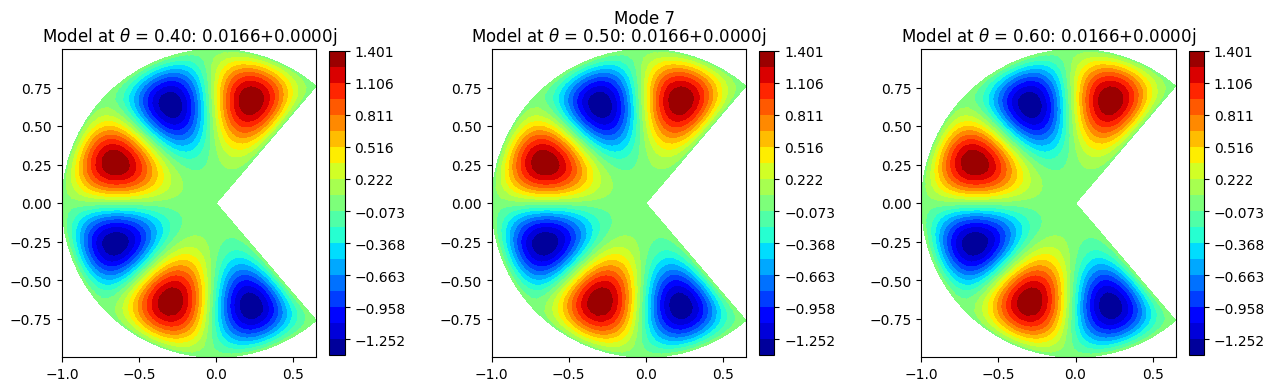

In [4]:
i = 7

plt.figure(figsize = (14,4))
plt.tight_layout()
plt.subplots_adjust(left = 0.05, wspace=0.3, hspace=0.3)

for m in range(3):
    plt.subplot(1,3,m+1)
    # mode = models[m].modeset[:,i]
    # mesh = models[m].mesh
    # V = FunctionSpace(mesh, "CG", 3)
    u = EF[m,i]
    levels = np.linspace(np.min(u.dat.data), np.max(u.dat.data), 20)
    contours = tricontourf(u, levels = levels, axes = plt.gca(),cmap="jet")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(contours, fraction=0.046, pad=0.04)
    plt.title(f'Model at $\\theta$ = {Theta[m]/pi:.2f}: {(1/EV[m,i]):.4f}')

plt.suptitle(f'Mode {i}')

Text(0.5, 0.98, 'Mode 8')

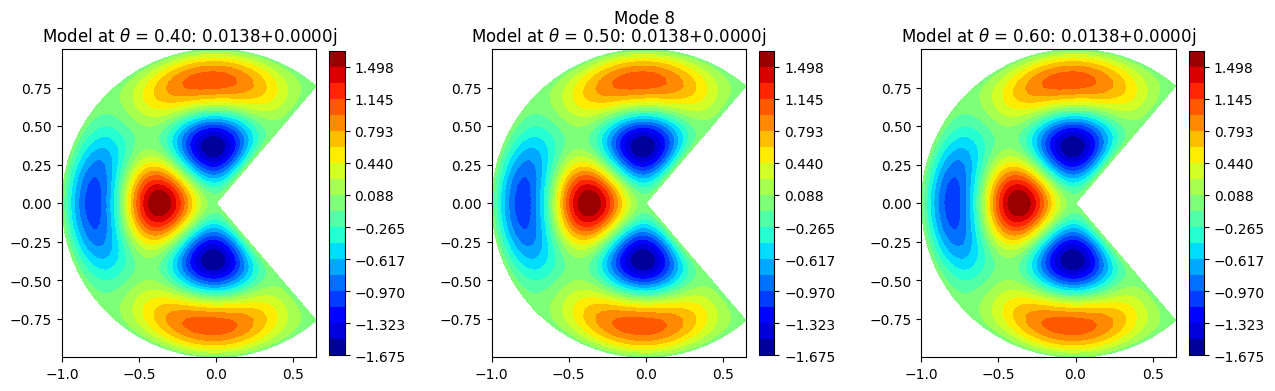

In [5]:
i = 8

plt.figure(figsize = (14,4))
plt.tight_layout()
plt.subplots_adjust(left = 0.05, wspace=0.3, hspace=0.3)

for m in range(3):
    plt.subplot(1,3,m+1)
    # mode = models[m].modeset[:,i]
    # mesh = models[m].mesh
    # V = FunctionSpace(mesh, "CG", 3)
    u = EF[m,i]
    levels = np.linspace(np.min(u.dat.data), np.max(u.dat.data), 20)
    contours = tricontourf(u, levels = levels, axes = plt.gca(),cmap="jet")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(contours, fraction=0.046, pad=0.04)
    plt.title(f'Model at $\\theta$ = {Theta[m]/pi:.2f}: {(1/EV[m,i]):.4f}')

plt.suptitle(f'Mode {i}')

In [6]:
eigenvalues, eigenfunctions = evproblem(theta = 0.55 * pi)

  1 EPS converged value (error) #0 11.6299 (2.00480645e-28)
  1 EPS converged value (error) #1 18.8272 (1.15503058e-19)
  1 EPS converged value (error) #2 27.3212 (6.14505944e-17)
  2 EPS converged value (error) #3 37.0675 (7.70767424e-20)
  2 EPS converged value (error) #4 43.1569 (2.83950303e-19)
  2 EPS converged value (error) #5 48.0346 (1.29107310e-17)
  3 EPS converged value (error) #6 57.1761 (6.14413899e-19)
  3 EPS converged value (error) #7 60.1981 (4.12740689e-17)
  4 EPS converged value (error) #8 72.5562 (1.43506886e-19)
  4 EPS converged value (error) #9 73.539 (4.76667452e-17)
 Linear eigensolve converged (10 eigenpairs) due to CONVERGED_TOL; iterations 4


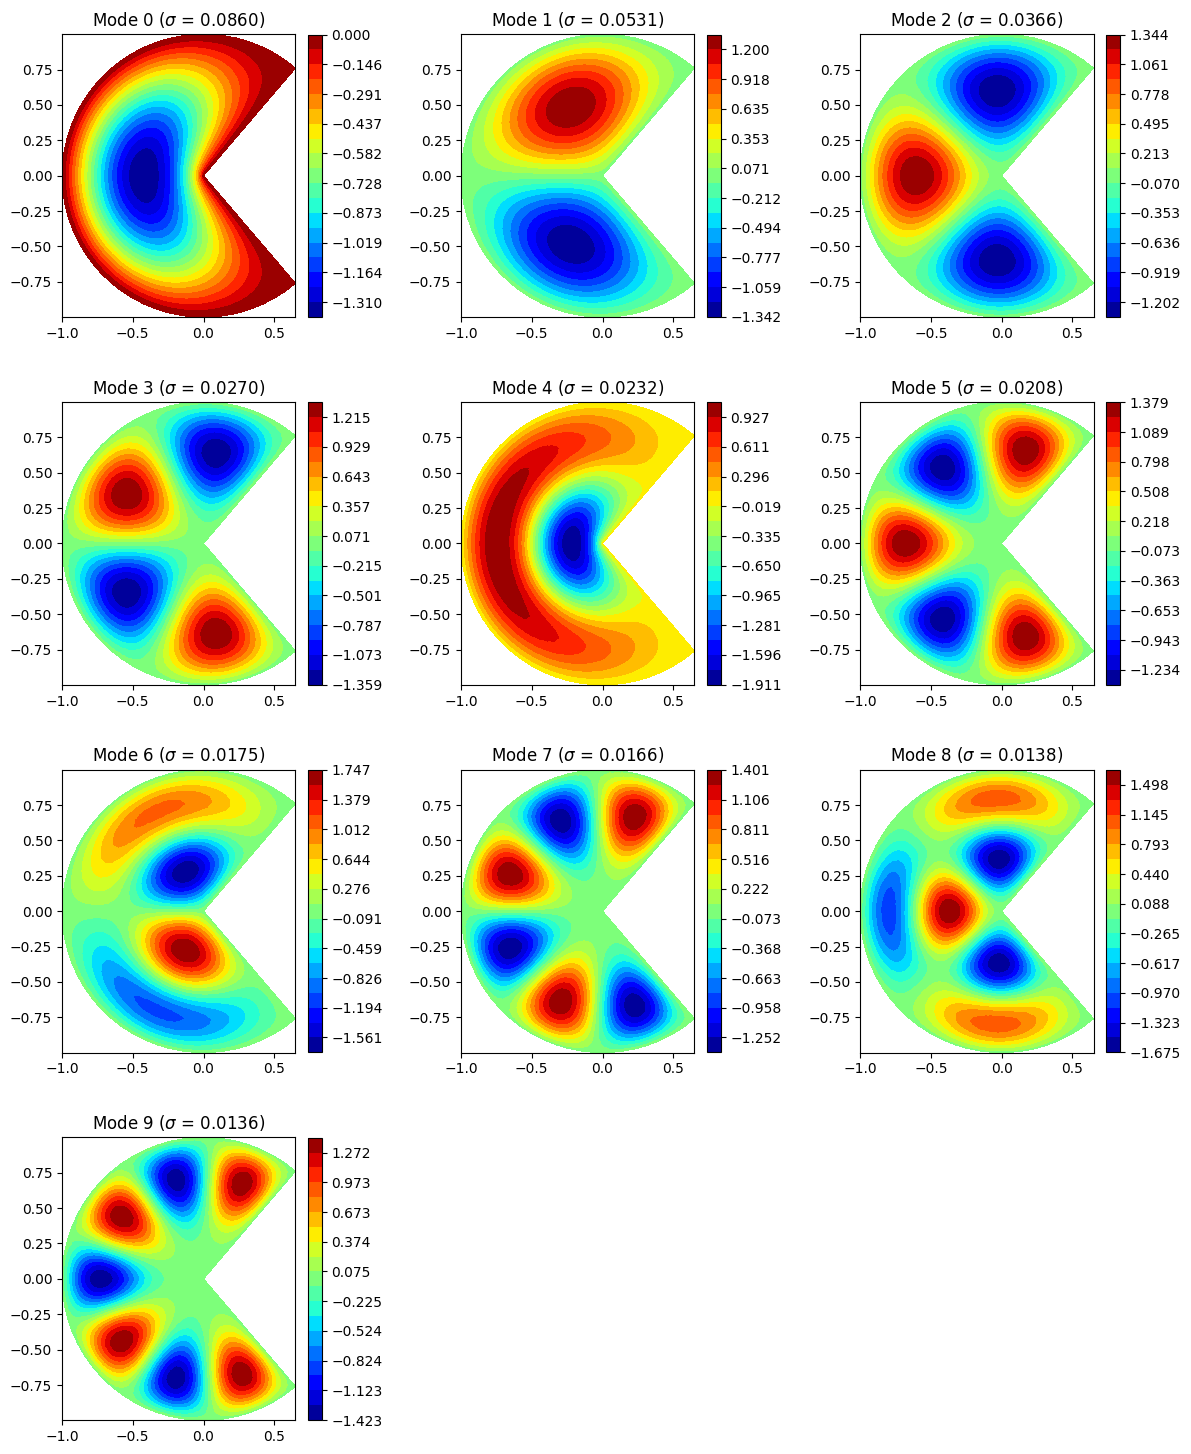

In [7]:
plt.figure(figsize = (13,4.5*4))
plt.tight_layout()
plt.subplots_adjust(left = 0.05, wspace=0.3, hspace=0.3)

for i in range(10):
    plt.subplot(4,3,i+1)
    u = eigenfunctions[i]
    levels = np.linspace(np.min(u.dat.data), np.max(u.dat.data), 20)
    contours = tricontourf(u, levels = levels, axes = plt.gca(),cmap="jet")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(contours, fraction=0.046, pad=0.04)
    plt.title(f'Mode {i} ($\\sigma$ = {np.real(1/eigenvalues[i]):.4f})')